In [ ]:
# KNN on CIFAR 100
import numpy as np
import cv2
from tensorflow.keras.datasets import cifar100
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter, maximum_filter, minimum_filter
from skimage.transform import rotate, rescale
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
# Load CIFAR-10 data
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
def apply_dog_and_detect_features(image, sigma1, sigma2, neighborhood_size):
    blurred_img1 = gaussian_filter(image, sigma=sigma1)
    blurred_img2 = gaussian_filter(image, sigma=sigma2)
    dog_img = blurred_img1 - blurred_img2
    local_max = (dog_img == maximum_filter(dog_img, size=neighborhood_size))
    local_min = (dog_img == minimum_filter(dog_img, size=neighborhood_size))
    features = local_max | local_min
    return np.argwhere(features)
# Grayscale conversion
def to_gray(image):
    return rgb2gray(image) * 255
# SIFT descriptor extraction
def extract_sift_features(images):
    sift = cv2.SIFT_create()
    all_descriptors = []
    for image in images:
        keypoints = [cv2.KeyPoint(x=float(pt[1]), y=float(pt[0]), size=1) for pt in apply_dog_and_detect_features(image, 0.5, 1.5, 5)]


        _, descriptors = sift.compute(to_gray(image).astype(np.uint8), keypoints)
        if descriptors is not None:
            all_descriptors.append(descriptors)
    return all_descriptors

# K-means for creating a visual vocabulary
def create_histograms(descriptors_list, kmeans):
    histograms = []
    for descriptors in descriptors_list:
        histogram = np.zeros(kmeans.n_clusters)
        if descriptors is not None:
            pred = kmeans.predict(descriptors)
            for p in pred:
                histogram[p] += 1
        histograms.append(histogram)
    return histograms

# Augment data
from skimage.transform import resize, rotate, rescale
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.color import rgb2gray
from skimage.transform import resize, rotate, rescale
import numpy as np
import numpy as np
import cv2
from tensorflow.keras.datasets import cifar10
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import classification_report, accuracy_score
from skimage.color import rgb2gray
from scipy.ndimage import gaussian_filter, laplace, maximum_filter

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

def augment_images_keras(images, batch_size):
    # Create an instance of the ImageDataGenerator class
    datagen = ImageDataGenerator(
        rotation_range=10,     # Rotate images by up to 20 degrees
        width_shift_range=0.1, # Shift images horizontally by up to 10%
        height_shift_range=0.1,# Shift images vertically by up to 10%
        rescale=1./255,        # Rescale the pixel values from [0, 255] to [0, 1]
        zoom_range=0.2,        # Randomly zoom into images
        horizontal_flip=True,  # Randomly flip images horizontally
        fill_mode='nearest'    # Fill in new pixels created by rotation or width/height shifting
    )

    # Ensure the input images are correctly shaped (num_images, height, width, channels)
    if images.ndim == 3:  # If the images are in shape (num_images, height, width), assume they are grayscale
        images = np.expand_dims(images, axis=-1)

    # Generate augmented images
    generator = datagen.flow(images, batch_size=batch_size, shuffle=False)
    augmented_images = next(generator)

    return augmented_images

# Example usage: Augment the first 10 images
X_train_aug = augment_images_keras(X_train, len(X_train))
# Check the shape of the augmented images
print("Shape of augmented_images array:", X_train_aug.shape)
y_train_aug = np.repeat(y_train, 3)  # Repeat labels for each augmented image

# Extract features from augmented training data
train_descriptors = extract_sift_features(X_train_aug)
all_train_desc = np.vstack(train_descriptors)  # Stack all descriptors

kmeans = MiniBatchKMeans(n_clusters=400, random_state=0)
kmeans.fit(all_train_desc)  # Fit KMeans

train_histograms = create_histograms(train_descriptors, kmeans)  # Create histograms
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(train_histograms, y_train)  # Train kNN

# Testing the classifier
test_descriptors = extract_sift_features(X_test)
test_histograms = create_histograms(test_descriptors, kmeans)
predictions = knn.predict(test_histograms)
print("Classification Report:\n", classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))

Shape of augmented_images array: (50000, 32, 32, 3)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Classification Report:
               precision    recall  f1-score   support

           0       0.05      0.18      0.08       100
           1       0.05      0.12      0.07       100
           2       0.02      0.06      0.03       100
           3       0.00      0.00      0.00       100
           4       0.02      0.04      0.02       100
           5       0.02      0.03      0.02       100
           6       0.01      0.01      0.01       100
           7       0.02      0.04      0.03       100
           8       0.01      0.02      0.01       100
           9       0.04      0.13      0.06       100
          10       0.01      0.03      0.02       100
          11       0.02      0.04      0.03       100
          12       0.02      0.05      0.02       100
          13       0.03      0.05      0.03       100
          14       0.01      0.01      0.01       100
          15       0.02      0.03      0.02       100
          16       0.04      0.09      0.06       100
   

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.datasets import cifar10
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter, maximum_filter, minimum_filter
from skimage.transform import rotate, rescale
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
# Load CIFAR-10 data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
def apply_dog_and_detect_features(image, sigma1, sigma2, neighborhood_size):
    blurred_img1 = gaussian_filter(image, sigma=sigma1)
    blurred_img2 = gaussian_filter(image, sigma=sigma2)
    dog_img = blurred_img1 - blurred_img2
    local_max = (dog_img == maximum_filter(dog_img, size=neighborhood_size))
    local_min = (dog_img == minimum_filter(dog_img, size=neighborhood_size))
    features = local_max | local_min
    return np.argwhere(features)
# Grayscale conversion
def to_gray(image):
    return rgb2gray(image) * 255
# SIFT descriptor extraction
def extract_sift_features(images):
    sift = cv2.SIFT_create()
    all_descriptors = []
    for image in images:
        keypoints = [cv2.KeyPoint(x=float(pt[1]), y=float(pt[0]), size=1) for pt in apply_dog_and_detect_features(image, 0.5, 1.5, 5)]


        _, descriptors = sift.compute(to_gray(image).astype(np.uint8), keypoints)
        if descriptors is not None:
            all_descriptors.append(descriptors)
    return all_descriptors

# K-means for creating a visual vocabulary
def create_histograms(descriptors_list, kmeans):
    histograms = []
    for descriptors in descriptors_list:
        histogram = np.zeros(kmeans.n_clusters)
        if descriptors is not None:
            pred = kmeans.predict(descriptors)
            for p in pred:
                histogram[p] += 1
        histograms.append(histogram)
    return histograms

# Augment data
from skimage.transform import resize, rotate, rescale
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.color import rgb2gray
from skimage.transform import resize, rotate, rescale
import numpy as np
import numpy as np
import cv2
from tensorflow.keras.datasets import cifar10
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import classification_report, accuracy_score
from skimage.color import rgb2gray
from scipy.ndimage import gaussian_filter, laplace, maximum_filter

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

def augment_images_keras(images, batch_size):
    # Create an instance of the ImageDataGenerator class
    datagen = ImageDataGenerator(
        rotation_range=15,     # Rotate images by up to 20 degrees
        width_shift_range=0.1, # Shift images horizontally by up to 10%
        height_shift_range=0.1,# Shift images vertically by up to 10%
        rescale=1./255,        # Rescale the pixel values from [0, 255] to [0, 1]
        zoom_range=0.2,        # Randomly zoom into images
        horizontal_flip=True,  # Randomly flip images horizontally
        fill_mode='nearest'    # Fill in new pixels created by rotation or width/height shifting
    )

    # Ensure the input images are correctly shaped (num_images, height, width, channels)
    if images.ndim == 3:  # If the images are in shape (num_images, height, width), assume they are grayscale
        images = np.expand_dims(images, axis=-1)

    # Generate augmented images
    generator = datagen.flow(images, batch_size=batch_size, shuffle=False)
    augmented_images = next(generator)

    return augmented_images

# Example usage: Augment the first 10 images
X_train_aug = augment_images_keras(X_train, len(X_train))
# Check the shape of the augmented images
print("Shape of augmented_images array:", X_train_aug.shape)
y_train_aug = np.repeat(y_train, 3)  # Repeat labels for each augmented image

# Extract features from augmented training data
train_descriptors = extract_sift_features(X_train_aug)
all_train_desc = np.vstack(train_descriptors)  # Stack all descriptors

kmeans = MiniBatchKMeans(n_clusters=250, random_state=0)
kmeans.fit(all_train_desc)  # Fit KMeans

train_histograms = create_histograms(train_descriptors, kmeans)  # Create histograms
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_histograms, y_train)  # Train kNN

# Testing the classifier
test_descriptors = extract_sift_features(X_test)
test_histograms = create_histograms(test_descriptors, kmeans)
predictions = knn.predict(test_histograms)
print("Classification Report:\n", classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))

Shape of augmented_images array: (50000, 32, 32, 3)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Classification Report:
               precision    recall  f1-score   support

           0       0.16      0.42      0.23      1000
           1       0.18      0.27      0.22      1000
           2       0.15      0.10      0.12      1000
           3       0.22      0.20      0.21      1000
           4       0.15      0.12      0.13      1000
           5       0.21      0.11      0.14      1000
           6       0.21      0.15      0.18      1000
           7       0.20      0.08      0.12      1000
           8       0.24      0.33      0.28      1000
           9       0.18      0.07      0.11      1000

    accuracy                           0.19     10000
   macro avg       0.19      0.19      0.17     10000
weighted avg       0.19      0.19      0.17     10000

Accuracy: 0.186


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


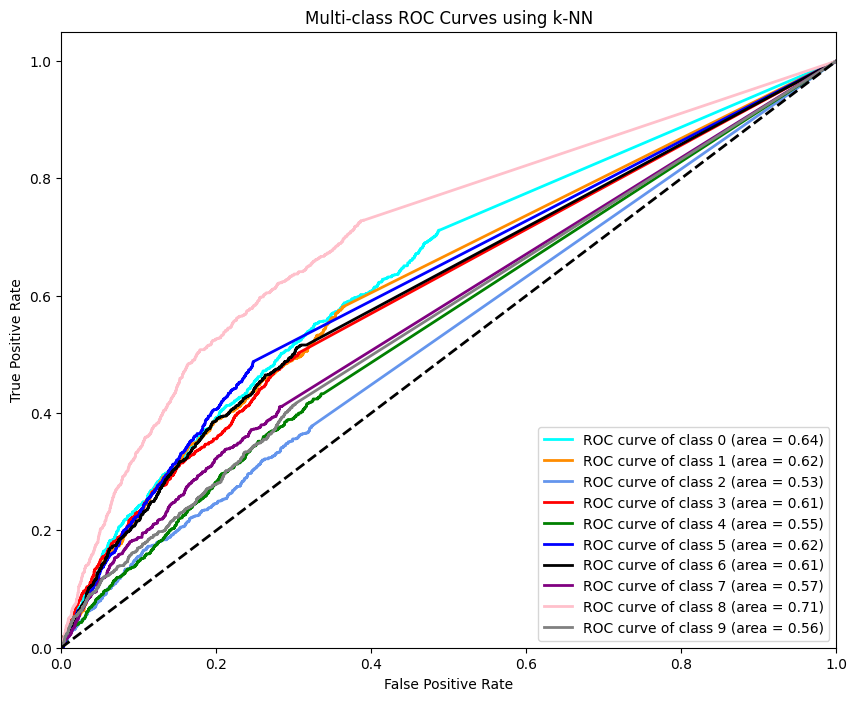

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
from scipy import interp

# Binarize the output classes for multi-class ROC analysis
y_bin = label_binarize(y_train, classes=np.unique(y_train))
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
n_classes = y_bin.shape[1]

# Train a k-NN classifier
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(train_histograms, y_train)  # Assuming train_histograms are your training features

# Predict probabilities (need to modify the k-NN slightly to handle multi-class probability output)
y_scores = knn.predict_proba(test_histograms)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'blue', 'black', 'purple', 'pink', 'gray'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves using k-NN')
plt.legend(loc="lower right")
plt.show()
